# Data treatment and Neural Network Training using IPMA data
João Oliveira and Edgar Mendes

In [7]:
#-----------------------Imports

import os
import requests
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import io
from io import BytesIO
from PIL import Image, ImageDraw
import pytz

#-----------------------Constantes

DADOS_ULTIMAS_3_HORAS = "https://api.ipma.pt/open-data/observation/meteorology/stations/obs-surface.geojson" #por exemplo se forem 9PM tem os dados entre 5PM e 7PM de hora a hora para todas as estações
DADOS_IDS_ESTACOES = "https://api.ipma.pt/open-data/observation/meteorology/stations/stations.json"
local_tz = pytz.timezone('Europe/Lisbon') #Define o fuso horário local

#-----------------------Funções

def get_data(url):
    response = requests.get(f"{url}")
    if response.status_code == 200:
        print("Sucessfully fetched the data!") 
        return response.json() #https://www.educative.io/answers/how-to-make-api-calls-in-python
    else:
        print(f"Hello there, there's a {response.status_code} error with your request.")
        
def normalize_precipitation_value(precipitation_value):
    return int(round((precipitation_value/240)*100,0)) #o valor normalizado ta a ser arredondado pq as pastas sao de valores inteiros. https://www.ipma.pt/pt/oclima/extremos.clima/ Vou usar o valor máximo aqui como referencia

def get_images_and_data_from_ipma():
    data = get_data(DADOS_ULTIMAS_3_HORAS)
    # Faz a requisição à apiEstacoes e à apiMeteo para obter as informações meteorológicas 
    box = (570, 428, 770, 628) # esses valores foram escolhidos por testes. coordenadas da região de Viana do Castelo (x1, y1, x2, y2) (1500x2331)

    final_result = {}
    for feature in data['features']:
        station_data = feature['properties']
        id_estacao = station_data['idEstacao']
        # Converte a hora da estação para o fuso horário local
        date_time_utc = datetime.fromisoformat(station_data['time'])
        date_time = datetime.fromisoformat(station_data['time']).replace(tzinfo=pytz.utc).astimezone(local_tz)
        date_str, hour_str = date_time.strftime('%Y-%m-%d %H:%M').split()
        precipitation = station_data['precAcumulada']

        if date_str not in final_result:
            final_result[date_str] = {hour_str: precipitation}
        else:
            final_result[date_str][hour_str] = normalize_precipitation_value(max(0, precipitation))

        url_image = f"https://www.ipma.pt/resources.www/transf/radar/por/pcr-{date_time_utc.strftime('%Y-%m-%d')}T{date_time_utc.strftime('%H%M')}.png"
        response = requests.get(url_image)
        image_data = io.BytesIO(response.content)
        image = Image.open(image_data)
        print(f"{url_image} ({hour_str}h)")

        # Corte da imagem
        # verifica se a pasta id_estacao existe e cria se não existir
        if not os.path.exists(f"dataset/images/{id_estacao}"):
            os.makedirs(f"dataset/images/{id_estacao}")

        # verifica se a pasta date_str existe e cria se não existir
        if not os.path.exists(f"dataset/images/{id_estacao}/{date_str}"):
            os.makedirs(f"dataset/images/{id_estacao}/{date_str}")

        # Corta a imagem na região definida pelas coordenadas se for de viana do castelo
        if int(id_estacao) == 1240610:
            region = image.crop(box)
            region.save(f"dataset/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")
            region.close()
        else:
            # Salva a imagem cortada como um arquivo PNG
            image.save(f"dataset/images/{id_estacao}/{date_str}/{date_time.strftime('%Y-%m-%dT%H%M')}.png")
        image.close()
        # Verifica se o arquivo JSON para esta estação já existe, se não, cria o arquivo
        filename = f"dataset/precipitation/{id_estacao}.json"
        if not os.path.isfile(filename):
            with open(filename, 'w') as file:
                json.dump({}, file)

        # Carrega o conteúdo do arquivo JSON para a variável "precipitation_data"
        with open(filename, 'r') as file:
            precipitation_data = json.load(file)

        # Adiciona as informações meteorológicas ao arquivo JSON
        for date in final_result:
            if date not in precipitation_data:
                precipitation_data[date] = final_result[date]
            else:
                precipitation_data[date].update(final_result[date])

        # Escreve o conteúdo atualizado no arquivo JSON
        with open(filename, 'w') as file:
            json.dump(precipitation_data, file, indent=4)

    print("Dados atualizados com sucesso!")
    
def dict_to_array(input_dict):
    # Create an empty list to hold the values
    output_array = np.empty(0)

    # Loop over each key-value pair in the dictionary
    for date_dict in input_dict.values():
        for value in date_dict.values():
            # Append the value to the output array
            output_array = np.append(output_array,value)

    # Return the output array
    return output_array


In [1]:
#--------Criação das pastas de 0 a 100

for i in range(101):
    os.mkdir(str(i)) #---Cria as pastas do 0 ao 100
print("Pastas criadas!")

Pastas criadas!


#  API Precipition Information
Observação Meteorológica de Estações, últimas 3 horas (formato GeoJSON) com as imagens (png)

(x1, y1, x2, y2) => (570, 428, 770, 628)


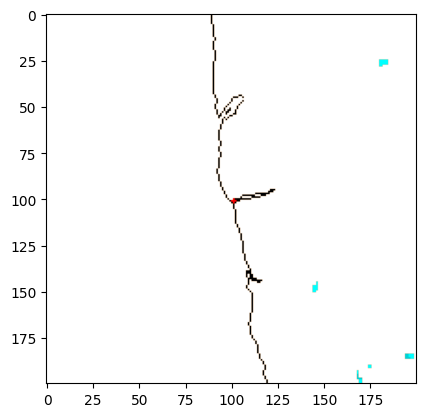

In [45]:
#--------Código auxiliar para o corte das regiões para a análise 

# Coordenadas da imagem (aproximação)
lat1, long1 = 43.95, -12.453377201650959
lat2, long2 = 34, -4.348615353313684

# Carrega a imagem
img = Image.open("dataset/teste.png")
dist = 200

# Coordenadas do ponto de corte (coordenadas da estação)
lat_corte, long_corte = 41.695, -8.82916 
    
#lat_corte, long_corte = 37.16925866835189, -7.40364787889199

# Calcula as coordenadas do canto superior esquerdo do corte ()
x = int(img.width * (long_corte - long1) / (long2 - long1) - (dist/2))
y = int(img.height * (lat_corte - lat1) / (lat2 - lat1) - (dist/2))
print(f'(x1, y1, x2, y2) => ({x}, {y}, {x + dist}, {y + dist})') # Mostra onde a imagem foi cortada (x1, y1, x2, y2)

# Desenha um ponto vermelho no centro da imagem
draw = ImageDraw.Draw(img)
draw.ellipse((x+(dist/2), y+(dist/2), x+((dist/2)+2), y+((dist/2)+2)), fill='red')

# Faz o corte de (dist x dist) pixels
corte = img.crop((x, y, x+dist, y+dist))

# Mostra a imagem cortada
plt.imshow(corte)
plt.show()

In [6]:
get_images_and_data_from_ipma()
#<class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDEBEF40>


Sucessfully fetched the data!
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DACFCBEAC0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DACFC9EE80>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD233AE50>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD233A910>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngIma

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDEBEF40>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDBACD60>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDBAC640>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDEBEDF0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Imag

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDBACF10>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADB669A60>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD233AF10>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDECB1F0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Imag

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD47DEC10>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADADF9820>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD47FD5E0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB5E640>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Imag

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDBAC670>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD47F6AC0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB4CD00>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB8E730>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1200.png (13:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Imag

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADADF97F0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB9F460>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB8E730>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADB669B20>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Imag

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD47FD430>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD47F8B20>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB5E3D0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB5E610>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Imag

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADB669A60>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD47F8D00>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DACFC9EDC0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DACFC9EC70>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Imag

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB5E3A0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD233A370>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD233AA00>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD233A1C0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1300.png (14:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Imag

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DACFC9E9A0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADAF08A00>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDBACAF0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB6E8B0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Imag

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD47DEE80>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADADF9790>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADB669A60>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB5E310>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Imag

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB5E5B0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB5E580>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB6E8B0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB8ABE0>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Imag

https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB9F460>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB9F580>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DAD1992A90>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Image: <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1500x2331 at 0x1DADDB5E700>
https://www.ipma.pt/resources.www/transf/radar/por/pcr-2023-04-15T1400.png (15:00h) <class 'PIL.PngImagePlugin.PngImageFile'> | Imag

# Model Training


In [30]:
#-----------------------Imports

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from keras import callbacks
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
import numpy as np
import base64
import io

#-----------------------Constantes

N_CHANNELS = 3
N_NEURONIOS = 32
FILTER_SIZE = 3
MAX_POOL_SIZE = (3,3)
N_CLASSES = 100
N_EPOCHS = 200
image_width, image_height = 200,200

In [31]:
images_array = np.empty(0)
data_array = np.empty(0)
# Open the JSON file
with open('dataset/precipitation/1240610.json') as f:
    # Load the JSON data
    data = json.load(f)

data_array = dict_to_array(data)

#-----------------------------------------

images_folder_path = 'dataset/images/1240610/'

# Get a list of all the files in the current folder
file_list = os.listdir(images_folder_path)

# Filter the list to only include folders files
days_folders_list = [file for file in file_list if os.path.isdir(os.path.join(images_folder_path, file))]

for day_folder in days_folders_list:
    current_path = images_folder_path + day_folder
    #Get a list of all files in the folder 
    files_list = os.listdir(current_path)
    # Filter the list to only include images files
    image_list = [file for file in files_list if file.endswith('.png')]
    for i in range(len(image_list)):
        image_path = os.path.join(current_path, image_list[i])
        #with open(image_path, "rb") as image:
            #image_string = base64.b64encode(image.read())
        #image = io.BytesIO(base64.b64decode(image_string))
        #image = tf.io.read_file(image_path)
        image = Image.open(image_path)
        #image_tensor = tf.image.decode_image(image, channels=3, dtype=tf.dtypes.float32)
        #image_tensor = tf.image.resize(image_tensor, [200, 200])
        image_tensor = tf.convert_to_tensor(np.asarray(image))
        
        images_array = np.append(images_array, image_tensor)
        
# Assuming your images are stored in a NumPy array called `images`
# and your values are stored in a NumPy array called `values`
print(image)
# Split the data into training and validation sets
# images_array = tf.keras.utils.normalize(images_array, axis=1)

train_images, val_images, train_values, val_values = train_test_split(images_array, data_array, test_size=0.2, random_state=42)

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=200x200 at 0x1DADE49E7C0>


ValueError: Found input variables with inconsistent numbers of samples: [3040000, 19]

In [35]:
print(images_array)

[212. 155.  95. ... 155.  95.   0.]


In [17]:
print(image)

#print(tf.shape(train_images))
#print(tf.shape(train_values))

#print(tf.shape(val_images))
#print(tf.shape(val_values))

tf.Tensor(b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xc8\x00\x00\x00\xc8\x08\x06\x00\x00\x00\xadX\xae\x9e\x00\x00\x06\xedIDATx\x9c\xed\xddKn\xdbV\x14\x06`\xa9\xc8*\xda\x1d\x04\x82\x87\xdeN2p\xb6\xe0Ex\x0b\xc9 YL;\xf0\xd0\x10\xbc\x83v\x1b\xeeDTh\xfa\xea\x88\xa4\xc8{\xc9\xcb\xef\x03\x0c\xa4yU1\xf4\xeb\x9c\xfb\xe4\xfe\xf8\xfd\xcb\x8ey\x1d\xbe\xfdz;~\xff\xb2/\xfd:\x18\xee\x8f\xd2/\x00\x96L@   \x10\x10\x10\x08\x08\x08\x04\x04$\x83\xe3\xf7/\xfb\xc3\xb7_o\xa5_\x07\xc3\t\x08\x04\x04\x04\x02\x02\x02\x01\x01\x81\x80\x80@@@   \x99\x98\xea]\'\x01\x81\x80\x80db\xcb\xfb:\t\x08\x04\x04\x04\x02\x02\x02\x01\x01\x81\xc0\xde\x99\xf4|\x0c\xd4\xa7s\xb8\x7f|7e~|~\x9a\xe5\xfb\xaa\x82@@@   \x10\x10\x10\x08\x08\x08U8\xdc?\xbeu\x07\xeeS\xf84\xf5_H\x9a\x19\xac\x89\xfd\xf3w\xfa\xe7\'~G\xab \x10\x10\x10V\xe9\xf8\xe9\xef,\xd5X\x8b\xc5j\xe5\x08\x89\n\x02\x01\x01\x81\x80\x80@@@   \x10\x10\x10\x08\x08\x08\x04\x04\x04\x02\x02\x02\x01\x01\x81\x80\x80@@@ `\xb3b\x85R\x07\x87\xe6\xba\xf5\xa3v*\x08\x04\xdc\x8b\x95\xd

In [16]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(N_NEURONIOS, FILTER_SIZE, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=MAX_POOL_SIZE))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(N_NEURONIOS*2, FILTER_SIZE, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=MAX_POOL_SIZE))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(N_NEURONIOS*4, FILTER_SIZE, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=MAX_POOL_SIZE))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(N_NEURONIOS*8, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

model.summary()

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(train_images, validation_data=(val_images, val_values), epochs=N_EPOCHS)
#history = model.fit(validation_data=(images_array, data_array),validation_split=0.2, epochs=N_EPOCHS)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 99, 99, 32)        9248      
                                                                 
 batch_normalization_14 (Bat  (None, 99, 99, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 33, 33, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_15 (Bat  (None, 33, 33, 32)       128       
 chNormalization)                                                
                                                      

ValueError: in user code:

    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "conv2d_8" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=True
      • mask=None
